# Data preparation

### Dataset creation

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

In [ ]:
df_docs = pd.read_parquet("/home/azureuser/cloudfiles/code/Users/rduffau/data/docs_with_pages_4K.parquet")

In [ ]:
df_evs = pd.read_parquet("/home/azureuser/cloudfiles/code/Users/rduffau/data/evs_qa_dataset.parquet")

In [ ]:
df_joined = pd.merge(df_evs, df_docs, on="idDocument")
del df_evs
del df_docs
import gc
gc.collect()

In [5]:
df_joined['textStr'] = [','.join(map(str, l)) for l in df_joined['textPerPage']]

In [6]:
df_joined['wordCount'] = df_joined['textStr'].apply(lambda x: len(x.split()))
df_joined['analystSourceExists'] = df_joined.analystSource.apply(lambda x: 0 if x is None else 1)
df_joined["percentQuest"] = df_joined.apply(lambda x: 1 if "percentage" in x["textQuestion"].lower() else 0, axis=1)
df_joined["cdpQuest"] = df_joined.apply(lambda x: 1 if "cdp" in x["textQuestion"].lower() else 0, axis=1)
df_joined["certificateQuest"] = df_joined.apply(lambda x: 1 if "certification" in x["textQuestion"].lower() else 0, axis=1)

### Gold-labelled Page verification

In [7]:
def removeFakePgNbrs(pageNbr):
    pageNbr = pageNbr.lower().replace("l0", "").replace("l-1", "").replace("l1", "")
    return pageNbr
    

def removeYears(pageNbr):
    l = re.findall(r'\d{4}', pageNbr)
    if len(l)!=0:
        for s in l:
            pageNbr = pageNbr.replace(s, '')
    return pageNbr


def getPagesWhenRange(pageNbr):
    pgs = re.search(r'\d+\s*-\s*\d+', pageNbr).group().split("-")
    start = int(pgs[0])-1
    end = int(pgs[1])
    range_nbr = list(range(start, end))
    others = re.findall(r'\d+', pageNbr)
    others = [int(i)-1 for i in others]
    all_pgs = range_nbr + others
    return list(set(all_pgs))
    

def cleanPageNbr(pageNbr):
    """
    :param pageNbr: non-standard text introduced by analyst
    :return: list of string : cleaned page numbers
    """
    pageNbr = str(pageNbr)
    pageNbr = removeFakePgNbrs(pageNbr)
    pageNbr = removeYears(pageNbr)
    if re.findall(r'\d+\s*-\s*\d+', pageNbr):
        pages = getPagesWhenRange(pageNbr)
        return pages 
    pages = re.findall(r'\d+', pageNbr)
    pages = [int(i)-1 for i in pages if i!= 0]
    return list(set(pages))

In [8]:
df_joined['answerPage'] = df_joined.apply(lambda x: cleanPageNbr(x['analystSource']), axis=1)

In [9]:
df_joined['answerPage'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                20596
[0]                 592
[1]                 211
[6]                 206
[5]                 196
                  ...  
[88, 27, 87]          1
[18, 37]              1
[1, 2, 26, 25]        1
[25, 26, 2, 1]        1
[16, 14]              1
Name: answerPage, Length: 1344, dtype: int64

### Creating shorter dataset for experiments

In [10]:
# Create shorter version of dataset with only useful rows
df_joined_short = df_joined[(df_joined.wordCount > 100) 
                            & (df_joined.wordCount < 100000)
                            & (df_joined.numPages > 1)  & (df_joined.cdOriginalLanguage == "en") 
                            & (df_joined.state == "Approved") & (df_joined.analystSourceExists == 1) 
                            & (df_joined.idQuestionType == 1) & (df_joined.percentQuest == 0)
                            & (df_joined.cdpQuest == 0) & (df_joined.certificateQuest == 0)
                            & (df_joined.answerPage != 'all')]
df_joined_short.reset_index(drop=False, inplace=True)
print("Number of questions-answers: ", len(df_joined_short))
print("Number of passages: ", df_joined_short.wordCount.sum()/100)

Number of questions-answers:  8350
Number of passages:  2159474.94


In [309]:
# Create shorter version of dataset with only useful rows (excluding rows with empty AnswerPage)
df_joined_short2 = df_joined[(df_joined.wordCount > 100) 
                            & (df_joined.wordCount < 100000)
                            & (df_joined.numPages > 1)  & (df_joined.cdOriginalLanguage == "en") 
                            & (df_joined.state == "Approved") & (df_joined.analystSourceExists == 1) 
                            & (df_joined.idQuestionType == 1) & (df_joined.percentQuest == 0)
                            & (df_joined.cdpQuest == 0) & (df_joined.certificateQuest == 0)
                            & (df_joined.answerPage != 'all')
                            & (df_joined.astype(str)['answerPage'] != '[]')]
df_joined_short2.reset_index(drop=False, inplace=True)
print("Number of questions-answers: ", len(df_joined_short2))
print("Number of passages: ", df_joined_short2.wordCount.sum()/100)

Number of questions-answers:  8164
Number of passages:  2151254.31


### Query creation

In [11]:
def extract_optionHelp(optionHelp):
    optionHelp = str(optionHelp)
    result = re.search(r'(?<=The document\(s\) should demonstrate the following: )\s*.*',optionHelp)
    if result:
        result = re.sub(r'(the reporting should cover.*)', '', result.group(0).lower())
        return result
    else:
        return ''
    
def select_query(option_help, option_text, question_text, question_type):
    option_help = extract_optionHelp(str(option_help))
    if len(option_help) != 0:
        query = option_help[:500]
        query_type = 'option_help'
        
    elif question_type == 2:
        query = question_text
        query_type = 'question_text'
    elif len(str(option_text).split()) > 4 and option_text != 'topics other than those mentioned above (please specify)':
        query = str(option_text).lower()
        query_type = 'option_text'
    else:
        query = str(question_text).lower() + ' ' + str(option_text).lower()
        query_type = 'concat_quest_opt'
        
    return (query, query_type)

df_joined_short['query'] = df_joined_short.apply(lambda x: select_query(x['optionHelp'], x['textOption'], x['textQuestion'], x['idQuestionType'])[0], axis=1)
df_joined_short['query_type'] = df_joined_short.apply(lambda x: select_query(x['optionHelp'], x['textOption'], x['textQuestion'], x['idQuestionType'])[1], axis=1)
df_joined_short['query_id'] = df_joined_short.index.values.tolist()

In [12]:
#Checking that simplication of Option_help worked well
df_joined_short[df_joined_short.query_type == "option_help"]['query'].iloc[6]

'public or internal reporting of consolidated data on energy consumption and greenhouse gas emissions from company operations. '

<AxesSubplot:>

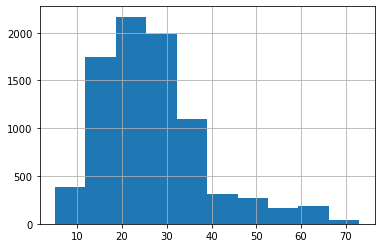

In [13]:
# Checking size of queries (in number of words)
df_joined_short['queryWordCount'] = df_joined_short['query'].apply(lambda x: len(x.split()))
df_joined_short['queryWordCount'].hist()

### Passages creation

In [14]:
# Tokenize and clean page text: split (simpler and faster), Word Tokenizer or TweetTokenizer (much longer to compute)
# Removing urls and html tags doesn't seem to improve results, but can be activated by removing comments below

import re
from math import ceil
#from nltk.tokenize import TweetTokenizer
#import nltk
#nltk.download('punkt')
#from nltk.tokenize import word_tokenize

#tk = TweetTokenizer()

def create_passages(text_list, passage_size):
    """ :param text_list: list of text pages (1 page per list item) 
        :param passage_size: expected size of each passage (recommended: between 100 and 200) 
        :return: list of triplets [page number, passage number in page, passage content]
    """ 
    passages = []
    page_id = 0
    global pass_id
    for text_words in text_list:
#        text_words = re.sub(r'https?://\S+', '', text_words)
#        text_words = re.sub(r'<.*?>', '', text_words)
        text_words = text_words.lower().split()
#        text_words = tk.tokenize(text_words.lower())
#        text_words = word_tokenize(text_words.lower())        
        if len(text_words) % passage_size < 30 and len(text_words) % passage_size > 0:
            passage_size2 = ceil(len(text_words) / ((len(text_words) // passage_size) + 1))
        else:
            passage_size2 = passage_size
        for i in range(0, len(text_words), passage_size2):
            passage = [page_id, pass_id, ' '.join(text_words[i:i+passage_size2])]
            if passage[2] != '':
                passages.append(passage)
                pass_id += 1
        page_id += 1
    return passages

In [15]:
pass_id = 0
df_joined_short['passages'] = df_joined_short['textPerPage'].apply(lambda x: create_passages(x, 100))
df_joined_short

,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,analystSourceExists,percentQuest,cdpQuest,certificateQuest,answerPage,query,query_type,query_id,queryWordCount,passages
0,3,2342,300,Provision of fuel consumption reduction inform...,Examples of documents to attach: product/servi...,Does your company provide services to clients ...,1,ENV420_10,300,ENV420,...,1,0,0,0,[22],detailed information available on fuel consump...,option_help,0,24,"[[0, 0, —toward the toyota environmental chall..."
1,4,9666,1202,Reduction of water consumption through employe...,Examples of documents to attach: training mate...,What actions are in place regarding water mana...,1,ENV321_10,28,ENV321,...,1,0,0,0,[50],company specific employee awareness programs g...,option_help,1,16,"[[0, 406, —toward the toyota environmental cha..."
2,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,1,0,0,0,[31],implementation of innovative equipment to enab...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha..."
3,6,10514,1300,Integration of ecodesign features in product d...,Examples of documents to attach: design specif...,What actions are in place to reduce the enviro...,1,ENV386_01,294,ENV386,...,1,0,0,0,[20],design of the product with special considerati...,option_help,3,29,"[[0, 1218, —toward the toyota environmental ch..."
4,7,10515,1300,Environmental impact analyses performed (e.g. ...,Examples of documents to attach: carbon footpr...,What actions are in place to reduce the enviro...,1,ENV386_02,294,ENV386,...,1,0,0,0,[12],environmental impact analysis of the product d...,option_help,4,51,"[[0, 1624, —toward the toyota environmental ch..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,32066,18512,2348,Health care coverage of employees in place,Examples of documents to attach: detailed heal...,What actions are in place regarding working co...,1,LAB3201_6,1737,LAB3201,...,1,0,0,0,[4],detailed coverage of company's specific health...,option_help,8345,24,"[[0, 2445552, 1 employee handbook 2019], [1, 2..."
8346,32067,18509,2348,Additional leave beyond standard vacation days,Examples of documents to attach: employee hand...,What actions are in place regarding working co...,1,LAB3201_3,1737,LAB3201,...,1,0,0,0,"[2, 3]",provision of additional leave beyond standard ...,option_help,8346,22,"[[0, 2445724, handbook employee], [1, 2445725,..."
8347,32069,18510,2348,Flexible organization of work available to emp...,Examples of documents to attach: standard oper...,What actions are in place regarding working co...,1,LAB3201_4,1737,LAB3201,...,1,0,0,0,[0],provision of flexible working arrangement (eg ...,option_help,8347,33,"[[0, 2445739, page 1 ypsomed holding ag brunnm..."
8348,32070,18512,2348,Health care coverage of employees in place,Examples of documents to attach: detailed heal...,What actions are in place regarding working co...,1,LAB3201_6,1737,LAB3201,...,1,0,0,0,[1],detailed coverage of company's specific health...,option_help,8348,24,"[[0, 2445746, handbook employee], [1, 2445747,..."


In [16]:
# Building a passage dictionnary to easily find the page number from which the passage is extracted
# Format: {passage_content : page_number of this passage}
passages_dict = {i[2]:i[0] for p in df_joined_short['passages'] for i in p}
len(passages_dict)

215608

Percentage of passages with more than 30 words:  0.9834328967385255


<AxesSubplot:>

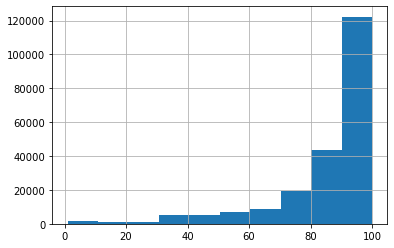

In [17]:
# Checking the range of passage lengths to ensure we have limited number of very small passages
import numpy as np
pass_text = passages_dict.keys()
pass_length = [len(p.split()) for p in pass_text]
df_pass_length = pd.Series(pass_length)
print("Percentage of passages with more than 30 words: ",df_pass_length[df_pass_length > 30].count()/df_pass_length.count())
df_pass_length.hist()

### Splitting dataset for training/testing along different dimensions

In [18]:
from sklearn.model_selection import train_test_split

# Split along query_ids
train_query_ids, test_query_ids = train_test_split(df_joined_short['query_id'], random_state=23, test_size = 0.2)
df_joined_train_query_ids = df_joined_short[df_joined_short['query_id'].isin(train_query_ids)]
df_joined_test_query_ids = df_joined_short[df_joined_short['query_id'].isin(test_query_ids)]
print('Split by Query Id')
print('Length train dataset: ', len(df_joined_train_query_ids))
print('Length test dataset: ', len(df_joined_test_query_ids))
print('\n')

# Split along supplier_ids
train_supplier_ids, test_supplier_ids = train_test_split(df_joined_short['idSupplier'].unique(), random_state=23, test_size = 0.2)
df_joined_train_supplier_ids = df_joined_short[df_joined_short['idSupplier'].isin(train_supplier_ids)]
df_joined_test_supplier_ids = df_joined_short[df_joined_short['idSupplier'].isin(test_supplier_ids)]
train_supplierIds_queryIds = df_joined_short[df_joined_short['idSupplier'].isin(train_supplier_ids)]['query_id']
test_supplierIds_queryIds = df_joined_short[df_joined_short['idSupplier'].isin(test_supplier_ids)]['query_id']
print('Split by Supplier Id')
print('Length train dataset: ', len(df_joined_train_supplier_ids))
print('Length test dataset: ', len(df_joined_test_supplier_ids))
print('\n')

# Checking overlap between lists of query_ids
print('Overlap between lists of query ids:')
print('Train overlap: ', len([i for i in train_supplierIds_queryIds if i in train_query_ids]))
print('Test overlap: ', len([i for i in test_supplierIds_queryIds if i in test_query_ids]))

Split by Query Id
Length train dataset:  6680
Length test dataset:  1670


Split by Supplier Id
Length train dataset:  6534
Length test dataset:  1816


Overlap between lists of query ids:
Train overlap:  5209
Test overlap:  345


In [19]:
df_joined_short.to_csv('df_joined_short.csv', index=False)

# BM25 baseline

In [20]:
df_bm25_full = df_joined_short.copy()
df_bm25_test_query_ids = df_joined_test_query_ids.copy()
df_bm25_test_supplier_ids = df_joined_test_supplier_ids.copy()

### BM25 top passages ranking on whole dataset

In [21]:
from gensim import corpora
from gensim.summarization import bm25
import logging
logging.getLogger("gensim").setLevel(logging.ERROR)

def bm25_rank(query, bm25_passages, num_passages):
    only_passages = [p[2] for p in bm25_passages]
    texts = [str(doc).split() for doc in only_passages]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    bm25_obj = bm25.BM25(corpus)
    query_doc = dictionary.doc2bow(query.split())
    scores = bm25_obj.get_scores(query_doc)
    best_docs_idx = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:min(len(scores),num_passages)]
    return [only_passages[i] for i in best_docs_idx]

In [22]:
import time
start_time = time.time()
df_bm25_full['bm25TopPassages'] = df_bm25_full.apply(lambda x: bm25_rank(x['query'], x['passages'], 200), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))
df_bm25_full

Execution time: 491.2500879764557 seconds


,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,percentQuest,cdpQuest,certificateQuest,answerPage,query,query_type,query_id,queryWordCount,passages,bm25TopPassages
0,3,2342,300,Provision of fuel consumption reduction inform...,Examples of documents to attach: product/servi...,Does your company provide services to clients ...,1,ENV420_10,300,ENV420,...,0,0,0,[22],detailed information available on fuel consump...,option_help,0,24,"[[0, 0, —toward the toyota environmental chall...",[fcev: expanded and improved fuel cell stack a...
1,4,9666,1202,Reduction of water consumption through employe...,Examples of documents to attach: training mate...,What actions are in place regarding water mana...,1,ENV321_10,28,ENV321,...,0,0,0,[50],company specific employee awareness programs g...,option_help,1,16,"[[0, 406, —toward the toyota environmental cha...",[ensure that all global employees are aware of...
2,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,0,0,0,[31],implementation of innovative equipment to enab...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha...",[region • contribute to air quality improvemen...
3,6,10514,1300,Integration of ecodesign features in product d...,Examples of documents to attach: design specif...,What actions are in place to reduce the enviro...,1,ENV386_01,294,ENV386,...,0,0,0,[20],design of the product with special considerati...,option_help,3,29,"[[0, 1218, —toward the toyota environmental ch...",[editorial policy contents overview highlights...
4,7,10515,1300,Environmental impact analyses performed (e.g. ...,Examples of documents to attach: carbon footpr...,What actions are in place to reduce the enviro...,1,ENV386_02,294,ENV386,...,0,0,0,[12],environmental impact analysis of the product d...,option_help,4,51,"[[0, 1624, —toward the toyota environmental ch...",[goals: international goals for the period fro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,32066,18512,2348,Health care coverage of employees in place,Examples of documents to attach: detailed heal...,What actions are in place regarding working co...,1,LAB3201_6,1737,LAB3201,...,0,0,0,[4],detailed coverage of company's specific health...,option_help,8345,24,"[[0, 2445552, 1 employee handbook 2019], [1, 2...",[group health insurance coverage if they lose ...
8346,32067,18509,2348,Additional leave beyond standard vacation days,Examples of documents to attach: employee hand...,What actions are in place regarding working co...,1,LAB3201_3,1737,LAB3201,...,0,0,0,"[2, 3]",provision of additional leave beyond standard ...,option_help,8346,22,"[[0, 2445724, handbook employee], [1, 2445725,...",[to the end of the current pay period. the pay...
8347,32069,18510,2348,Flexible organization of work available to emp...,Examples of documents to attach: standard oper...,What actions are in place regarding working co...,1,LAB3201_4,1737,LAB3201,...,0,0,0,[0],provision of flexible working arrangement (eg ...,option_help,8347,33,"[[0, 2445739, page 1 ypsomed holding ag brunnm...",[page 2 about the ypsomed group the ypsomed gr...
8348,32070,18512,2348,Health care coverage of employees in place,Examples of documents to attach: detailed heal...,What actions are in place regarding working co...,1,LAB3201_6,1737,LAB3201,...,0,0,0,[1],detailed coverage of company's specific health...,option_help,8348,24,"[[0, 2445746, handbook employee], [1, 2445747,...",[platform is designed to attract and retain mo...


In [23]:
df_bm25_full.to_csv('df_bm25_full.csv', index=False)

### BM25 top passages ranking on query_id test set

In [24]:
import time
start_time = time.time()
df_bm25_test_query_ids['bm25TopPassages'] = df_bm25_test_query_ids.apply(lambda x: bm25_rank(x['query'], x['passages'], 200), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))
df_bm25_test_query_ids

Execution time: 97.66662120819092 seconds


,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,percentQuest,cdpQuest,certificateQuest,answerPage,query,query_type,query_id,queryWordCount,passages,bm25TopPassages
2,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,0,0,0,[31],implementation of innovative equipment to enab...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha...",[region • contribute to air quality improvemen...
11,31,16986,2157,Company specific take back programs (e.g. free...,Examples of documents to attach: work instruct...,What actions are in place to reduce environmen...,1,ENV388_10,295,ENV388,...,0,0,0,[32],take-back program at the end of the products' ...,option_help,11,18,"[[0, 4466, —toward the toyota environmental ch...",[the water is life 2018 (global high school st...
15,38,17130,2170,Monitoring direct CO2 emissions,Examples of documents to attach: third-party t...,What actions are in place regarding the reduct...,1,ENV312_70,20,ENV312,...,0,0,0,[22],company monitoring mechanism to keep track of ...,option_help,15,24,"[[0, 6090, —toward the toyota environmental ch...",[governments as well as local communities and ...
17,40,17132,2170,Measures to reduce CO2 emissions from transport,Examples of documents to attach: standard oper...,What actions are in place regarding the reduct...,1,ENV312_90,20,ENV312,...,0,0,0,[24],operational processes or deployment of technol...,option_help,17,28,"[[0, 6902, —toward the toyota environmental ch...","[nature (iucn) at an un conference, and donati..."
28,198,16368,2076,Energy Consumption & GHGs,Examples of documents to attach: annual energy...,On which of the following topics does your com...,1,ENV600_1,1993,ENV600,...,0,0,0,[41],public or internal reporting of consolidated d...,option_help,28,17,"[[0, 9870, sustainability report 2018], [1, 98...",[2 e emission reduction were realized. as a re...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8314,31993,18202,2300,Incident response procedure (IRP) to manage br...,Examples of documents to attach: standard oper...,What actions are in place regarding informatio...,1,FB3301_5,1600,FB3301,...,0,0,0,"[0, 1, 2, 3]","employee instructions or procedure to detect, ...",option_help,8314,24,"[[0, 2443618, issuing organisation: document n...","[the measures taken, or proposed to be taken, ..."
8325,32015,18204,2300,Measures to protect third party data from unau...,Examples of documents to attach: work instruct...,What actions are in place regarding informatio...,1,FB3301_10,1600,FB3301,...,0,0,0,[3],internal controls to restrict physical or digi...,option_help,8325,18,"[[0, 2444079, privacy notice last updated: jan...",[information from children under thirteen 13 y...
8327,32017,19684,2533,Measures to protect third party data from unau...,Examples of documents to attach: work instruct...,What actions are in place regarding informatio...,1,FB3301_10,1600,FB3301,...,0,0,0,[3],internal controls to restrict physical or digi...,option_help,8327,18,"[[0, 2444197, privacy notice last updated: jan...",[information from children under thirteen 13 y...
8329,32019,18204,2300,Measures to protect third party data from unau...,Examples of documents to attach: work instruct...,What actions are in place regarding informatio...,1,FB3301_10,1600,FB3301,...,0,0,0,"[0, 1, 2, 3, 4, 5, 6, 7]",internal controls to restrict physical or digi...,option_help,8329,18,"[[0, 2444315, website privacy statement avaya ...",[that your privacy rights continue to be prote...


In [346]:
df_bm25_test_query_ids.to_csv('df_bm25_test_query_ids.csv', index=False)

### BM25 top passages ranking on supplier_id test set

In [25]:
import time
start_time = time.time()
df_bm25_test_supplier_ids['bm25TopPassages'] = df_bm25_test_supplier_ids.apply(lambda x: bm25_rank(x['query'], x['passages'], 200), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))
df_bm25_test_supplier_ids

Execution time: 100.79172587394714 seconds


,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,percentQuest,cdpQuest,certificateQuest,answerPage,query,query_type,query_id,queryWordCount,passages,bm25TopPassages
75,424,4760,649,Company products and services to facilitate re...,Examples of documents to attach: product/servi...,What actions are in place regarding promotion ...,1,CP331_30,8,CP331,...,0,0,0,[18],detailed information on take back or recycling...,option_help,75,26,"[[0, 20506, corporate social responsibility v....",[rainwater collector i two separate projects s...
76,425,9666,1202,Reduction of water consumption through employe...,Examples of documents to attach: training mate...,What actions are in place regarding water mana...,1,ENV321_10,28,ENV321,...,0,0,0,[14],company specific employee awareness programs g...,option_help,76,16,"[[0, 20569, corporate social responsibility v....",[support local social organisations gardening/...
77,427,9670,1202,Others (please specify),Please select this option only if the rest of ...,What actions are in place regarding water mana...,1,ENV321_40_999,28,ENV321,...,0,0,0,[13],what actions are in place regarding water mana...,concat_quest_opt,77,11,"[[0, 20632, corporate social responsibility v....",[our six adopted csr action areas save energy ...
78,434,17073,2166,Reduction of energy consumption through techno...,Examples of documents to attach: standard oper...,What actions are in place regarding the reduct...,1,ENV310_30,240,ENV310,...,0,0,0,[10],deployment of certain technology or equipment ...,option_help,78,14,"[[0, 20695, corporate social responsibility v....",[investments in presses & controls quick set-u...
79,437,17507,2208,Active recycling program for paper/carton,Examples of documents to attach: standard oper...,What actions are in place regarding hazardous ...,1,ENV356_10,40,ENV356,...,0,0,0,[17],employee instructions or operational process t...,option_help,79,13,"[[0, 20758, corporate social responsibility v....",[support local social organisations customers ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,31999,18204,2300,Measures to protect third party data from unau...,Examples of documents to attach: work instruct...,What actions are in place regarding informatio...,1,FB3301_10,1600,FB3301,...,0,0,0,[1],internal controls to restrict physical or digi...,option_help,8318,18,"[[0, 2443810, home data protection/ data prote...",[important information about the safeguarding ...
8337,32052,18486,2346,Regular assessment (at least once a year) of i...,Examples of documents to attach: standard oper...,What actions are in place regarding training a...,1,LAB340_20,105,LAB340,...,0,0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",employee instructions or operational process t...,option_help,8337,19,"[[0, 2444471, 2019 yer process . dl briefing. ...",[2019 yer process . dl briefing. for business ...
8346,32067,18509,2348,Additional leave beyond standard vacation days,Examples of documents to attach: employee hand...,What actions are in place regarding working co...,1,LAB3201_3,1737,LAB3201,...,0,0,0,"[2, 3]",provision of additional leave beyond standard ...,option_help,8346,22,"[[0, 2445724, handbook employee], [1, 2445725,...",[to the end of the current pay period. the pay...
8347,32069,18510,2348,Flexible organization of work available to emp...,Examples of documents to attach: standard oper...,What actions are in place regarding working co...,1,LAB3201_4,1737,LAB3201,...,0,0,0,[0],provision of flexible working arrangement (eg ...,option_help,8347,33,"[[0, 2445739, page 1 ypsomed holding ag brunnm...",[page 2 about the ypsomed group the ypsomed gr...


In [348]:
df_bm25_test_supplier_ids.to_csv('df_bm25_test_supplier_ids.csv', index=False)

### Analyzing results

In [ ]:
# Reimporting the whole dataset with results of BM25 predictions
import ast
import pandas as pd
df_bm25_full = pd.read_csv('df_bm25_full.csv')
df_bm25_full['bm25TopPassages'] = df_bm25_full['bm25TopPassages'].apply(lambda x: ast.literal_eval(x))
df_bm25_full['passages'] = df_bm25_full['passages'].apply(lambda x: ast.literal_eval(x))
df_bm25_full['answerPage'] = df_bm25_full['answerPage'].apply(lambda x: ast.literal_eval(x))
passages_dict = {i[2]:i[0] for p in df_bm25_full['passages'] for i in p}
df_bm25_full.head()

In [ ]:
# Reimporting the query_id test dataset with results of BM25 predictions
import ast
import pandas as pd
df_bm25_test_query_ids = pd.read_csv('df_bm25_test_query_ids.csv')
df_bm25_test_query_ids['bm25TopPassages'] = df_bm25_test_query_ids['bm25TopPassages'].apply(lambda x: ast.literal_eval(x))
df_bm25_test_query_ids['passages'] = df_bm25_test_query_ids['passages'].apply(lambda x: ast.literal_eval(x))
df_bm25_test_query_ids['answerPage'] = df_bm25_test_query_ids['answerPage'].apply(lambda x: ast.literal_eval(x))
passages_dict = {i[2]:i[0] for p in df_bm25_test_query_ids['passages'] for i in p}
df_bm25_test_query_ids.head()

In [ ]:
# Reimporting the supplier_id test dataset with results of BM25 predictions
import ast
import pandas as pd
df_bm25_test_supplier_ids = pd.read_csv('df_bm25_test_supplier_ids.csv')
df_bm25_test_supplier_ids['bm25TopPassages'] = df_bm25_test_supplier_ids['bm25TopPassages'].apply(lambda x: ast.literal_eval(x))
df_bm25_test_supplier_ids['passages'] = df_bm25_test_supplier_ids['passages'].apply(lambda x: ast.literal_eval(x))
df_bm25_test_supplier_ids['answerPage'] = df_bm25_test_supplier_ids['answerPage'].apply(lambda x: ast.literal_eval(x))
passages_dict = {i[2]:i[0] for p in df_bm25_test_supplier_ids['passages'] for i in p}
df_bm25_test_supplier_ids.head()

In [349]:
# Scoring success on top k results
def predict_pages_BM25(k, BM25_top_passage, answer_page):
    prediction = 0
    for j in range(k):
        try:
            if passages_dict[BM25_top_passage[j]] in answer_page:
                prediction = 1 
        except:
            pass
    return prediction

In [350]:
# Running the evaluation on whole dataset
print('Results on whole dataset:')
for k in [1,3,5,10]:
    results = df_bm25_full.apply(lambda x: predict_pages_BM25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on whole dataset:
Success @ 1: 0.211416
Success @ 3: 0.373714
Success @ 5: 0.458599
Success @ 10: 0.579128


In [180]:
# Investigating the distribution of Success@3 depending on the type of report
import itertools

grouped_type = df_bm25_full.groupby('typeName')['query_id', 'answerPage', 'numPages', 'bm25TopPassages']
df_bm25_full_type = grouped_type.aggregate(lambda x: list(x))
df_bm25_full_type = df_bm25_full_type.reset_index()
df_bm25_full_type['numPages'] = df_bm25_full_type['numPages'].apply(lambda x: np.mean(x))
#df_bm25_full_type['query_id'] = df_bm25_full_type['query_id'].apply(lambda x: int(str(list(set(x))).strip('[]')))
df_bm25_full_type['answerPage'] = df_bm25_full_type['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_bm25_full_type

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,typeName,query_id,answerPage,numPages,bm25TopPassages
0,Annual_Report,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...","[[34, 27], [27], [90], [53], [41, 95], [41, 4]...",97.171956,[[deadlines contain action plans to reach the ...
1,Audit_Report,"[5207, 5208, 5209, 5210, 5211, 5212, 5213, 521...","[[24], [20], [23], [20], [28], [32], [26], [44...",28.487805,[[safe and healthy workplace. failure to compl...
2,CSR_Report,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","[[38], [34], [27], [21], [41], [42], [41, 42],...",71.816555,"[[in 2018, 126 suppliers were evaluated in ter..."
3,Certificate,"[2377, 3875, 4176, 4190, 4216, 4217, 4244, 530...","[[0], [0, 1, 2, 3, 4, 5, 6, 7, 8], [0, 1, 2, 3...",8.625000,[[fairtrade certificate sucafina s.a. flo id 5...
4,Code_of_Ethics_Code_of_Conduct,"[898, 899, 900, 2350, 2351, 2352, 2553, 2554, ...","[[], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...",19.844498,[[code of conduct for huhtamaki suppliers | da...
5,Employee_Handbook,"[431, 432, 433, 434, 435, 436, 437, 438, 453, ...","[[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, ...",56.364130,[[with the performance of your job or create a...
6,Letter_to_EcoVadis,"[5236, 5237, 5238, 5239, 5240, 5241, 5242]","[[66], [21], [44], [25], [29, 30], [12], [39]]",82.000000,[[comment gefco awards program (stim) allows a...
7,Other,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[22], [50], [31], [20], [12], [51], [26, 54],...",43.613583,[[fcev: expanded and improved fuel cell stack ...
8,Policy,"[439, 440, 441, 442, 443, 444, 445, 446, 447, ...","[[42], [14], [21], [20], [23], [32], [15], [18...",29.066964,[[make sure no outside persons can hear your c...
9,Procedure,"[169, 171, 630, 631, 1665, 1666, 1667, 1780, 1...","[[], [0, 1, 2], [10], [12], [0, 1, 2, 3], [0, ...",16.050388,[[head of department (hod) shall take all prac...


In [181]:
types = df_bm25_full_type['typeName'].tolist()
print('Success @ 3 for type:')
for s in types:
    index_s = types.index(s)
    query_idx = df_bm25_full_type.query_id.iloc[types.index(s)]
    df_types_temp = df_bm25_full[df_bm25_full['query_id'].isin(query_idx)]
    results = df_types_temp.apply(lambda x: predict_pages_BM25(3, x['bm25TopPassages'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {} with average {:.0f} pages: {:f}".format(s, df_bm25_full_type['numPages'].iloc[index_s], sum(results)/len(results)))

Success @ 3 for type:
  Annual_Report with average 97 pages: 0.296068
  Audit_Report with average 28 pages: 0.414634
  CSR_Report with average 72 pages: 0.282899
  Certificate with average 9 pages: 0.625000
  Code_of_Ethics_Code_of_Conduct with average 20 pages: 0.555024
  Employee_Handbook with average 56 pages: 0.395652
  Letter_to_EcoVadis with average 82 pages: 0.000000
  Other with average 44 pages: 0.466042
  Policy with average 29 pages: 0.584821
  Procedure with average 16 pages: 0.596899
  Supplier_Code_of_Conduct with average 11 pages: 0.600000
  Webpage_Intranet_extract with average 6 pages: 0.716535


In [351]:
# Investigating the distribution of Success@3 depending on the size of the documents

def page_range(x):
    if x < 31:
        pageRange = '2-30'
    elif x < 61:
        pageRange = '31-60'
    else:
        pageRange = '61-more'
    return pageRange

df_bm25_full['pageRange'] = df_bm25_full['numPages'].apply(lambda x: page_range(x))
df_bm25_full['pageRange'].value_counts()

61-more    3608
31-60      2343
2-30       2213
Name: pageRange, dtype: int64

In [352]:
import itertools

grouped_range = df_bm25_full.groupby('pageRange')['query_id', 'answerPage', 'numPages', 'bm25TopPassages']
df_bm25_full_range = grouped_range.aggregate(lambda x: list(x))
df_bm25_full_range = df_bm25_full_range.reset_index()
df_bm25_full_range['numPages'] = df_bm25_full_range['numPages'].apply(lambda x: np.mean(x))
df_bm25_full_range['answerPage'] = df_bm25_full_range['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])

ranges = df_bm25_full_range['pageRange'].tolist()
print('Success @ 3 for range:')
for s in ranges:
    index_s = ranges.index(s)
    query_idx = df_bm25_full_range.query_id.iloc[ranges.index(s)]
    df_ranges_temp = df_bm25_full[df_bm25_full['query_id'].isin(query_idx)]
    results = df_ranges_temp.apply(lambda x: predict_pages_BM25(3, x['bm25TopPassages'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {}: {:f}".format(s, sum(results)/len(results)))

Success @ 3 for range:
  2-30: 0.624040
  31-60: 0.323517
  61-more: 0.252772


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [353]:
# Scoring MRR on top k results
def eval_MRR_bm25(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_bm25_full.apply(lambda x: eval_MRR_bm25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.211416
MRR @ 3: 0.280969
MRR @ 5: 0.300261
MRR @ 10: 0.316450


In [354]:
# Running the evaluation on query_id test set
print('Results on query_id test set:')
for k in [1,3,5,10]:
    results = df_bm25_test_query_ids.apply(lambda x: predict_pages_BM25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on query_id test set:
Success @ 1: 0.225352
Success @ 3: 0.396816
Success @ 5: 0.481935
Success @ 10: 0.593386


In [355]:
# Scoring MRR on top k results
def eval_MRR_bm25(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_bm25_test_query_ids.apply(lambda x: eval_MRR_bm25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.225352
MRR @ 3: 0.298939
MRR @ 5: 0.318596
MRR @ 10: 0.333668


In [356]:
# Running the evaluation on supplier_id test set
print('Results on supplier_id test set:')
for k in [1,3,5,10]:
    results = df_bm25_test_supplier_ids.apply(lambda x: predict_pages_BM25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on supplier_id test set:
Success @ 1: 0.199772
Success @ 3: 0.359704
Success @ 5: 0.439385
Success @ 10: 0.545248


In [357]:
# Scoring MRR on top k results
def eval_MRR_bm25(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_bm25_test_supplier_ids.apply(lambda x: eval_MRR_bm25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.199772
MRR @ 3: 0.269778
MRR @ 5: 0.287934
MRR @ 10: 0.302291


In [184]:
# Manual inspection
import random
df_temp_bm25 = df_bm25_full.copy()
#df_temp_bm25 = df_bm25_test_query_ids.copy()
#df_temp_bm25 = df_bm25_test_supplier_ids.copy()
idx = random.randint(0, len(df_temp_bm25))
print('Index: ', idx)
print('Query type: ', df_temp_bm25['query_type'].iloc[idx])
print('Query: ', df_temp_bm25['query'].iloc[idx])
print('\n')
print('Answer pages by Analysts: ', df_temp_bm25['answerPage'].iloc[idx])
print('Total pages number in doc: ', df_temp_bm25['numPages'].iloc[idx])
print("\n")
print("Top passage #1: [{}] {}".format(passages_dict[df_temp_bm25['bm25TopPassages'].iloc[idx][0]], df_temp_bm25['bm25TopPassages'].iloc[idx][0]))
print("\n")
print("Top passage #2: [{}] {}".format(passages_dict[df_temp_bm25['bm25TopPassages'].iloc[idx][1]], df_temp_bm25['bm25TopPassages'].iloc[idx][1]))
print("\n")
print("Top passage #3: [{}] {}".format(passages_dict[df_temp_bm25['bm25TopPassages'].iloc[idx][2]], df_temp_bm25['bm25TopPassages'].iloc[idx][2]))

Index:  7203
Query type:  option_help
Query:  established mechanism for different parties to report any cases of discrimination and/or harassment and inclusion of 1) confidentiality guarantee 2) non-retaliation guarantee and 3) dedicated reporting channel (ie internal or third-party email, phone/hotline, contact person in compliance department.).


Answer pages by Analysts:  [53]
Total pages number in doc:  61.0


Top passage #1: [14] the committee (management, hod & hr) shall be responsible for the proposal of concerned promotion. in case of exceptional performance by a member, above guidelines for promotion can be altered with permission from management. promotion shall mainly depend upon the following criteria: - 1) performance of member 2) availability of positions 3) as per the guidelines and policy structure of increment the increments are categorized in a five point scale as excellent, very good, good, fair & unsatisfactory. the increments are classified in the mentioned group a

In [26]:
### Using BM25 predictions to separate positive and negative passages
def pos_passages(top_passages, col_answerPage):
    pos_passages = [top_passages[i] for i in range(len(top_passages)) if passages_dict[top_passages[i]] in col_answerPage]
    return pos_passages

def neg_passages(top_passages, col_answerPage):
    neg_passages = [top_passages[i] for i in range(len(top_passages)) if passages_dict[top_passages[i]] not in col_answerPage]
    return neg_passages

passages_dict = {i[2]:i[0] for p in df_bm25_full['passages'] for i in p}

df_bm25_full['bm25posPassages'] = df_bm25_full.apply(lambda x: pos_passages(x['bm25TopPassages'], x['answerPage']), axis=1)
df_bm25_full['bm25negPassages'] = df_bm25_full.apply(lambda x: neg_passages(x['bm25TopPassages'], x['answerPage']), axis=1)

df_bm25_test_query_ids['bm25posPassages'] = df_bm25_test_query_ids.apply(lambda x: pos_passages(x['bm25TopPassages'], x['answerPage']), axis=1)
df_bm25_test_query_ids['bm25posPassages'] = df_bm25_test_query_ids.apply(lambda x: neg_passages(x['bm25TopPassages'], x['answerPage']), axis=1)

df_bm25_test_supplier_ids['bm25negPassages'] = df_bm25_test_supplier_ids.apply(lambda x: pos_passages(x['bm25TopPassages'], x['answerPage']), axis=1)
df_bm25_test_supplier_ids['bm25negPassages'] = df_bm25_test_supplier_ids.apply(lambda x: neg_passages(x['bm25TopPassages'], x['answerPage']), axis=1)

In [27]:
df_bm25_full.to_csv('df_bm25_full.csv', index=False)

# PyGaggle T5 baseline

In [6]:
from pygaggle.rerank.base import Query, Text
from pygaggle.rerank.transformer import MonoT5

reranker =  MonoT5()

2021-05-30 13:50:28 [INFO] loader: Loading faiss with AVX2 support.
2021-05-30 13:50:28 [INFO] loader: Loading faiss.
Some weights of the model checkpoint at castorini/monot5-base-msmarco were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### PyGaggle Reranker on whole dataset

In [ ]:
# Creating queries and passages in PyGaggle formats
df_joined_short['pygaggleQuery'] = df_joined_short['query'].apply(lambda x: Query(x))
df_joined_short['pygagglePassages'] = df_joined_short['passages'].apply(lambda x: [Text(p[2], {'docid': p[1]}, 0) for p in x])

In [ ]:
# To test the T5 reranker on a sample of the dataset
df_joined_veryshort = df_joined_short[(df_joined_short.wordCount < 500)]
print("Number of questions-answers: ", len(df_joined_veryshort))
print("Number of passages: ", df_joined_veryshort.wordCount.sum()/100)

In [ ]:
#df_T5 = df_joined_veryshort.copy()
df_T5_full = df_joined_short.copy()

In [ ]:
import time
start_time = time.time()
df_T5_full['rerankedPassages'] = df_T5_full.apply(lambda x: reranker.rerank(x['pygaggleQuery'], x['pygagglePassages']), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))

In [ ]:
# Extracting the top 100 passages per query
def top_100_passages(texts):
    top_list = []
    for i in range(0, min(100,len(texts))):
        top_list.append([i+1, texts[i].metadata["docid"], texts[i].score, texts[i].text])
    return top_list

df_T5_full['T5Top100Passages'] = df_T5_full['rerankedPassages'].apply(lambda x: top_100_passages(x))

In [ ]:
df_T5_full.to_csv('df_T5_full.csv', index=False)

### PyGaggle Reranker on query_id test set

In [7]:
# Creating queries and passages in PyGaggle formats
df_joined_test_query_ids['pygaggleQuery'] = df_joined_test_query_ids['query'].apply(lambda x: Query(x))
df_joined_test_query_ids['pygagglePassages'] = df_joined_test_query_ids['passages'].apply(lambda x: [Text(p[2], {'docid': p[1]}, 0) for p in x])
df_T5_test_query_ids = df_joined_test_query_ids.copy()

In [ ]:
import time
start_time = time.time()
df_T5_test_query_ids['rerankedPassages'] = df_T5_test_query_ids.apply(lambda x: reranker.rerank(x['pygaggleQuery'], x['pygagglePassages']), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))

In [ ]:
# Extracting the top 100 passages per query
def top_100_passages(texts):
    top_list = []
    for i in range(0, min(100,len(texts))):
        top_list.append([i+1, texts[i].metadata["docid"], texts[i].score, texts[i].text])
    return top_list

df_T5_test_query_ids['T5Top100Passages'] = df_T5_test_query_ids['rerankedPassages'].apply(lambda x: top_100_passages(x))

In [ ]:
df_T5_test_query_ids.to_csv('df_T5_test_query_ids.csv', index=False)

### PyGaggle Reranker on supplier_id test set

In [ ]:
# Creating queries and passages in PyGaggle formats
df_joined_test_supplier_ids['pygaggleQuery'] = df_joined_test_supplier_ids['query'].apply(lambda x: Query(x))
df_joined_test_supplier_ids['pygagglePassages'] = df_joined_test_supplier_ids['passages'].apply(lambda x: [Text(p[2], {'docid': p[1]}, 0) for p in x])
df_T5_test_supplier_ids = df_joined_test_supplier_ids.copy()

In [ ]:
import time
start_time = time.time()
df_T5_test_supplier_ids['rerankedPassages'] = df_T5_test_supplier_ids.apply(lambda x: reranker.rerank(x['pygaggleQuery'], x['pygagglePassages']), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))

In [ ]:
# Extracting the top 100 passages per query
def top_100_passages(texts):
    top_list = []
    for i in range(0, min(100,len(texts))):
        top_list.append([i+1, texts[i].metadata["docid"], texts[i].score, texts[i].text])
    return top_list

df_T5_test_supplier_ids['T5Top100Passages'] = df_T5_test_supplier_ids['rerankedPassages'].apply(lambda x: top_100_passages(x))

In [ ]:
df_T5_test_supplier_ids.to_csv('df_T5_test_supplier_ids.csv', index=False)

### Analyze results

In [58]:
# Reimporting the whole dataset with results of T5 predictions
import ast
df_T5_full = pd.read_csv('df_T5_top100.csv')
df_T5_full['T5Top100Passages'] = df_T5_full['T5Top100Passages'].apply(lambda x: ast.literal_eval(x))
df_T5_full['passages'] = df_T5_full['passages'].apply(lambda x: ast.literal_eval(x))
df_T5_full['answerPage'] = df_T5_full['answerPage'].apply(lambda x: ast.literal_eval(x))
passages_dict = {i[2]:i[0] for p in df_T5_full['passages'] for i in p}
df_T5_full.head()

,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,query_type,query_id,queryWordCount,passages,pygaggleQuery,pygagglePassages,rerankedPassages,T5Top100Passages,T5posPassages,T5negPassages
0,3,2342,300,Provision of fuel consumption reduction inform...,Examples of documents to attach: product/servi...,Does your company provide services to clients ...,1,ENV420_10,300,ENV420,...,option_help,0,24,"[[0, 0, —toward the toyota environmental chall...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 162, -0.09654336422681808, data of the re...","[[2, 152, -2.076173782348633, 'stage. in this ...","[[1, 162, -0.09654336422681808, 'data of the r..."
1,4,9666,1202,Reduction of water consumption through employe...,Examples of documents to attach: training mate...,What actions are in place regarding water mana...,1,ENV321_10,28,ENV321,...,option_help,1,16,"[[0, 406, —toward the toyota environmental cha...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 768, -0.02047719992697239, ensure that al...","[[37, 755, -9.55618953704834, 'to protect huma...","[[1, 768, -0.02047719992697239, 'ensure that a..."
2,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 862, -0.6157100796699524, at newly establ...","[[7, 1027, -8.945672988891602, 'makes it imper...","[[1, 862, -0.6157100796699524, 'at newly estab..."
3,6,10514,1300,Integration of ecodesign features in product d...,Examples of documents to attach: design specif...,What actions are in place to reduce the enviro...,1,ENV386_01,294,ENV386,...,option_help,3,29,"[[0, 1218, —toward the toyota environmental ch...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 1370, -0.20025764405727386, stage. in thi...","[[11, 1359, -5.017537593841553, 'to curb globa...","[[1, 1370, -0.20025764405727386, 'stage. in th..."
4,7,10515,1300,Environmental impact analyses performed (e.g. ...,Examples of documents to attach: carbon footpr...,What actions are in place to reduce the enviro...,1,ENV386_02,294,ENV386,...,option_help,4,51,"[[0, 1624, —toward the toyota environmental ch...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 1776, -0.015775874257087708, stage. in th...","[[4, 1692, -0.03989306464791298, 'will contrib...","[[1, 1776, -0.015775874257087708, 'stage. in t..."


In [219]:
# Rebuilding query_id and supplier_id test sets with T5 predictions
df_T5_test_query_ids = df_T5_full[df_T5_full['query_id'].isin(test_query_ids)]

df_T5_test_supplier_ids = df_T5_full[df_T5_full['query_id'].isin(test_supplierIds_queryIds)]

In [59]:
# Scoring success on top k results
def predict_pages_T5(k, T5_top_passage, answer_page):
    prediction = 0
    for j in range(k):
        try:
            if passages_dict[T5_top_passage[j][3]] in answer_page:
                prediction = 1 
        except:
            pass
    return prediction

In [449]:
# Running the evaluation on whole dataset
print('Results on whole dataset:')

for k in [1,3,5,10]:
    results = df_T5_full.apply(lambda x: predict_pages_T5(k, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on whole dataset:
Success @ 1: 0.407305
Success @ 3: 0.591377
Success @ 5: 0.659042
Success @ 10: 0.745269


In [222]:
# Investigating the distribution of Success@3 depending on the type of report
import itertools

grouped_type_T5 = df_T5_full.groupby('typeName')['query_id', 'answerPage', 'numPages', 'T5Top100Passages']
df_T5_full_type = grouped_type_T5.aggregate(lambda x: list(x))
df_T5_full_type = df_T5_full_type.reset_index()
df_T5_full_type['numPages'] = df_T5_full_type['numPages'].apply(lambda x: np.mean(x))
#df_bm25_full_type['query_id'] = df_bm25_full_type['query_id'].apply(lambda x: int(str(list(set(x))).strip('[]')))
df_T5_full_type['answerPage'] = df_T5_full_type['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_T5_full_type

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,typeName,query_id,answerPage,numPages,T5Top100Passages
0,Annual_Report,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...","[[34, 27], [27], [90], [53], [41, 95], [41, 4]...",97.171956,"[[[1, 20902, -0.042886167764663696, 31 the amb..."
1,Audit_Report,"[5207, 5208, 5209, 5210, 5211, 5212, 5213, 521...","[[24], [20], [23], [20], [28], [32], [26], [44...",28.487805,"[[[1, 1807338, -0.11901791393756866, personal ..."
2,CSR_Report,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","[[38], [34], [27], [21], [41], [42], [41, 42],...",71.816555,"[[[1, 8576, -2.580763101577759, s u st a in a ..."
3,Certificate,"[2377, 3875, 4176, 4190, 4216, 4217, 4244, 530...","[[0], [0, 1, 2, 3, 4, 5, 6, 7, 8], [0, 1, 2, 3...",8.625000,"[[[1, 821124, -0.4873693585395813, fairtrade c..."
4,Code_of_Ethics_Code_of_Conduct,"[898, 899, 900, 2350, 2351, 2352, 2553, 2554, ...","[[], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...",19.844498,"[[[1, 226072, -0.061277732253074646, legal per..."
5,Employee_Handbook,"[431, 432, 433, 434, 435, 436, 437, 438, 453, ...","[[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, ...",56.364130,"[[[1, 131281, -5.9307966232299805, includes: (..."
6,Letter_to_EcoVadis,"[5236, 5237, 5238, 5239, 5240, 5241, 5242]","[[66], [21], [44], [25], [29, 30], [12], [39]]",82.000000,"[[[1, 1811050, -1.772041916847229, co2 program..."
7,Other,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[22], [50], [31], [20], [12], [51], [26, 54],...",43.613583,"[[[1, 162, -0.09654336422681808, data of the r..."
8,Policy,"[439, 440, 441, 442, 443, 444, 445, 446, 447, ...","[[42], [14], [21], [20], [23], [32], [15], [18...",29.066964,"[[[1, 132955, -0.09250561147928238, care of ti..."
9,Procedure,"[169, 171, 630, 631, 1665, 1666, 1667, 1780, 1...","[[], [0, 1, 2], [10], [12], [0, 1, 2, 3], [0, ...",16.050388,"[[[1, 36058, -0.012019116431474686, head of de..."


In [223]:
T5_types = df_T5_full_type['typeName'].tolist()
print('Success @ 3 for type:')
for s in T5_types:
    index_s_T5 = T5_types.index(s)
    query_idx_T5 = df_T5_full_type.query_id.iloc[T5_types.index(s)]
    df_types_temp_T5 = df_T5_full[df_T5_full['query_id'].isin(query_idx_T5)]
    results = df_types_temp_T5.apply(lambda x: predict_pages_T5(3, x['T5Top100Passages'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {} with average {:.0f} pages: {:f}".format(s, df_T5_full_type['numPages'].iloc[index_s_T5], sum(results)/len(results)))

Success @ 3 for type:
  Annual_Report with average 97 pages: 0.559450
  Audit_Report with average 28 pages: 0.658537
  CSR_Report with average 72 pages: 0.532141
  Certificate with average 9 pages: 0.562500
  Code_of_Ethics_Code_of_Conduct with average 20 pages: 0.734450
  Employee_Handbook with average 56 pages: 0.688043
  Letter_to_EcoVadis with average 82 pages: 0.142857
  Other with average 44 pages: 0.576112
  Policy with average 29 pages: 0.696429
  Procedure with average 16 pages: 0.682171
  Supplier_Code_of_Conduct with average 11 pages: 0.636364
  Webpage_Intranet_extract with average 6 pages: 0.787402


In [453]:
# Scoring MRR on top k results
def eval_MRR_T5(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j][3]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_T5_full.apply(lambda x: eval_MRR_T5(k, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.407305
MRR @ 3: 0.488104
MRR @ 5: 0.503523
MRR @ 10: 0.515100


In [224]:
# Running the evaluation on query_id test set
print('Results on query_id test set:')

for k in [1,3,5,10]:
    results = df_T5_test_query_ids.apply(lambda x: predict_pages_T5(k, df_T5_test_query_ids, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on query_id test set:
Success @ 1: 0.393413
Success @ 3: 0.580240
Success @ 5: 0.654491
Success @ 10: 0.752695


In [64]:
# Investigating the distribution of Success@3 depending on the size of the documents

def page_range(x):
    if x < 31:
        pageRange = '2-30'
    elif x < 61:
        pageRange = '31-60'
    else:
        pageRange = '61-more'
    return pageRange

df_T5_full['pageRange'] = df_T5_full['numPages'].apply(lambda x: page_range(x))

import itertools

grouped_range_T5 = df_T5_full.groupby('pageRange')['query_id', 'answerPage', 'numPages', 'T5Top100Passages']
df_T5_full_range = grouped_range_T5.aggregate(lambda x: list(x))
df_T5_full_range = df_T5_full_range.reset_index()
df_T5_full_range['numPages'] = df_T5_full_range['numPages'].apply(lambda x: np.mean(x))
df_T5_full_range['answerPage'] = df_T5_full_range['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])

T5_ranges = df_T5_full_range['pageRange'].tolist()
print('Success @ 3 for range:')
for s in T5_ranges:
    index_s_T5 = T5_ranges.index(s)
    query_idx_T5 = df_T5_full_range.query_id.iloc[T5_ranges.index(s)]
    df_ranges_temp_T5 = df_T5_full[df_T5_full['query_id'].isin(query_idx_T5)]
    results = df_ranges_temp_T5.apply(lambda x: predict_pages_T5(3, x['T5Top100Passages'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {}: {:f}".format(s, sum(results)/len(results)))

Success @ 3 for range:
  2-30: 0.716091
  31-60: 0.578925
  61-more: 0.517575


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


In [454]:
# Scoring MRR on top k results
def eval_MRR_T5(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j][3]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_T5_test_query_ids.apply(lambda x: eval_MRR_T5(k, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.393413
MRR @ 3: 0.475349
MRR @ 5: 0.492086
MRR @ 10: 0.504962


In [225]:
# Running the evaluation on supplier_id test set
print('Results on supplier_id test set:')

for k in [1,3,5,10]:
    results = df_T5_test_supplier_ids.apply(lambda x: predict_pages_T5(k, df_T5_test_supplier_ids, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on supplier_id test set:
Success @ 1: 0.416850
Success @ 3: 0.615088
Success @ 5: 0.681718
Success @ 10: 0.775881


In [462]:
# Scoring MRR on top k results
def eval_MRR_T5(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j][3]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_T5_test_supplier_ids.apply(lambda x: eval_MRR_T5(k, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.416850
MRR @ 3: 0.503120
MRR @ 5: 0.518264
MRR @ 10: 0.530735


In [226]:
# Manual inspection
import random
df_temp = df_T5_full.copy()
#df_temp = df_T5_test_query_ids.copy()
#df_temp = df_T5_test_supplier_ids.copy()
idx = random.randint(0, len(df_temp)-1)
print('Index: ', idx)
print('Query type: ', df_temp['query_type'].iloc[idx])
print('Query: ', df_temp['query'].iloc[idx])
print('\n')
print('Answer pages by Analysts: ', df_temp['answerPage'].iloc[idx])
print('Total pages number in doc: ', df_temp['numPages'].iloc[idx])
print("\n")
print("Top passage #1: [{}] {}".format(passages_dict[df_temp['T5Top100Passages'].iloc[idx][0][3]], df_temp['T5Top100Passages'].iloc[idx][0]))
print("\n")
print("Top passage #2: [{}] {}".format(passages_dict[df_temp['T5Top100Passages'].iloc[idx][1][3]], df_temp['T5Top100Passages'].iloc[idx][1]))
print("\n")
print("Top passage #3: [{}] {}".format(passages_dict[df_temp['T5Top100Passages'].iloc[idx][2][3]], df_temp['T5Top100Passages'].iloc[idx][2]))
print("\n")
#print("Source Text: ", df_T5.textStr.iloc[idx])

Index:  6818
Query type:  option_help
Query:  training programs in web-based or in-person format provided to employees to strengthen their knowledge on external stakeholders human rights related to the company's operation. examples of external stakeholders human rights are land rights, indigenous rights, right to clean water, etc.


Answer pages by Analysts:  [34]
Total pages number in doc:  72.0


Top passage #1: [35] [1, 2207725, -0.012813732959330082, 'of our employees received training on aspects of our human rights policy in sessions totaling around 238,000 hours. aspects of human rights are also covered in the training offerings and the sustainability manual for our suppliers. if there are indica- tions of violations of our human rights policy, employees and members of the general public can contact the world- wide compliance hotline, which is available in numerous national languages. this can also be done anonymously if desired. we verify the observation of human rights at our s

In [227]:
### Using T5 predictions to separate positive and negative passages
def pos_passages(top_passages, col_answerPage):
    pos_passages = [top_passages[i] for i in range(len(top_passages)) if passages_dict[top_passages[i][3]] in col_answerPage]
    return pos_passages

def neg_passages(top_passages, col_answerPage):
    neg_passages = [top_passages[i] for i in range(len(top_passages)) if passages_dict[top_passages[i][3]] not in col_answerPage]
    return neg_passages

df_T5_full['T5posPassages'] = df_T5_full.apply(lambda x: pos_passages(x['T5Top100Passages'], x['answerPage']), axis=1)
df_T5_full['T5negPassages'] = df_T5_full.apply(lambda x: neg_passages(x['T5Top100Passages'], x['answerPage']), axis=1)

df_T5_test_query_ids['T5posPassages'] = df_T5_test_query_ids.apply(lambda x: pos_passages(x['T5Top100Passages'], x['answerPage']), axis=1)
df_T5_test_query_ids['T5negPassages'] = df_T5_test_query_ids.apply(lambda x: neg_passages(x['T5Top100Passages'], x['answerPage']), axis=1)

df_T5_test_supplier_ids['T5posPassages'] = df_T5_test_supplier_ids.apply(lambda x: pos_passages(x['T5Top100Passages'], x['answerPage']), axis=1)
df_T5_test_supplier_ids['T5negPassages'] = df_T5_test_supplier_ids.apply(lambda x: neg_passages(x['T5Top100Passages'], x['answerPage']), axis=1)

In [ ]:
df_T5_full.to_csv('df_T5_full.csv', index=False)
df_T5_test_query_ids.to_csv('df_T5_test_query_ids.csv', index=False)
df_T5_test_supplier_ids.to_csv('df_T5_test_supplier_ids.csv', index=False)